In [196]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [272]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [273]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [274]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [275]:
len(main_df)

775

In [276]:
main_df['refactoring_perc_time_taken'] = main_df['refactoring_perc'] * main_df['time_taken']

In [510]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

def plotGraphandSave(y_test,y_pred,y_test_str,y_pred_str,regressorName,img_name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.savefig(f'model_prediction_images/{img_name}.png')
    plt.show()
    return





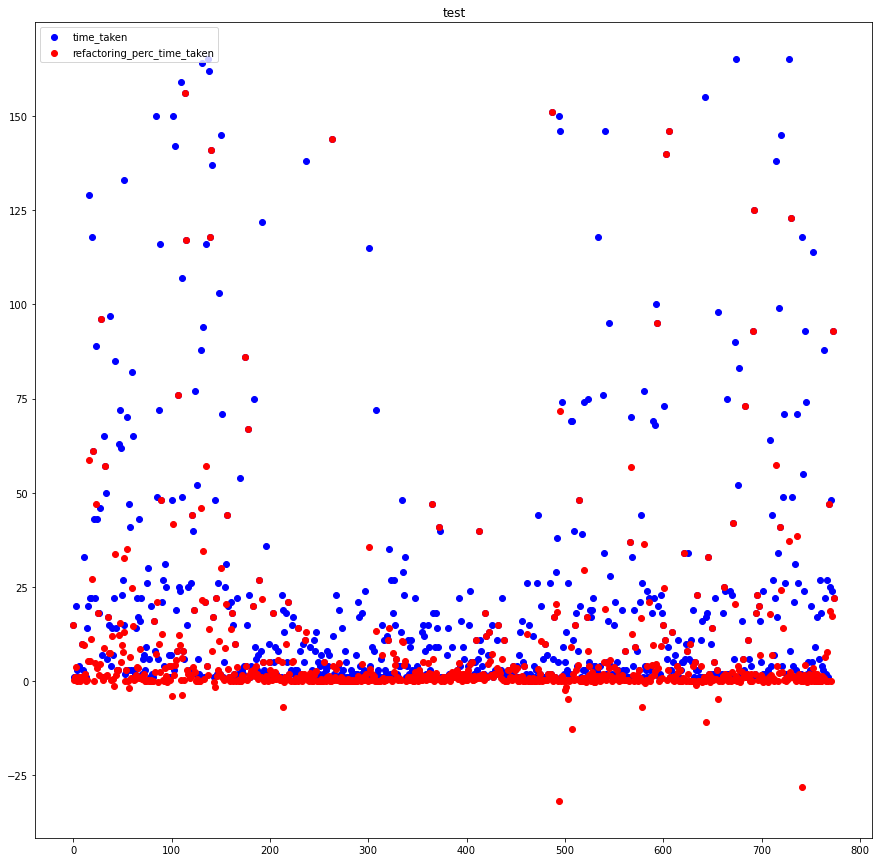

In [278]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],'time_taken','refactoring_perc_time_taken','test')

In [279]:
main_df = main_df[main_df['refactoring_perc_time_taken'] > 0]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 8]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

In [280]:
main_df['refactoring_perc_time_taken'].value_counts()

1.000000    27
2.000000    23
3.000000    11
4.000000     6
5.000000     6
            ..
0.318253     1
1.628895     1
4.387500     1
1.800000     1
0.473684     1
Name: refactoring_perc_time_taken, Length: 517, dtype: int64

In [281]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [282]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [283]:
#plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x25d96845780>,
 'caps': [<matplotlib.lines.Line2D at 0x25d9683e278>,
 'boxes': [<matplotlib.lines.Line2D at 0x25d968459e8>],
 'medians': [<matplotlib.lines.Line2D at 0x25d9683e978>],
 'fliers': [<matplotlib.lines.Line2D at 0x25d9683ecf8>],
 'means': []}

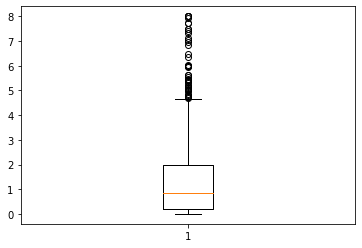

In [284]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x25d96862940>,
 'caps': [<matplotlib.lines.Line2D at 0x25d9686f0b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x25d968627f0>],
 'medians': [<matplotlib.lines.Line2D at 0x25d9686f7b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x25d9686fb38>],
 'means': []}

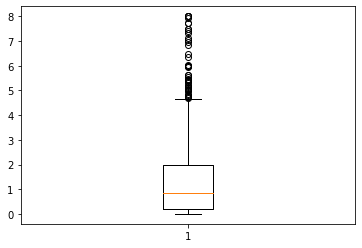

In [285]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [286]:
main_df['time_taken_final'].value_counts()

1.0     128
2.0      69
3.0      29
4.0      27
6.0      26
       ... 
26.6      1
11.2      1
8.8       1
20.4      1
1.6       1
Name: time_taken_final, Length: 66, dtype: int64

In [287]:
main_df = main_df.fillna(0)

In [288]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,0.000000,346,0.225434,0.225434,179.03424,107.076009,2229.76,519.589347,0.0
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.707107,35,1.000000,1.000000,18.11040,10.840124,189.60,113.234791,0.0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,13,4.018895,194,0.185567,3.711340,100.38336,60.060503,1232.64,353.641141,1.0
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,136,50.585661,1938,0.004128,0.012384,1002.79872,597.273303,12673.28,1634.048307,2.0
5,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.707107,371,0.865229,0.865229,191.97024,114.805271,2393.76,544.262337,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,19,0.000000,6803,0.010731,0.944289,3520.14432,2070.058368,44587.68,3766.348005,15.0
40,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,17,0.000000,714,0.288515,6.347339,369.45216,220.749445,4643.84,841.170325,1.0
42,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,32,16.743158,635,0.286614,7.738583,328.57440,196.365047,4125.60,778.070877,6.0
43,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,7,1.964427,615,0.053659,0.053659,318.22560,190.190193,3994.40,761.687072,0.0


(array([292., 111.,  67.,  37.,  26.,  20.,  19.,   8.,   5.,  11.]),
 array([1.20827670e-04, 8.00108745e-01, 1.60009666e+00, 2.40008458e+00,
        3.20007250e+00, 4.00006041e+00, 4.80004833e+00, 5.60003625e+00,
        6.40002417e+00, 7.20001208e+00, 8.00000000e+00]),
 <a list of 10 Patch objects>)

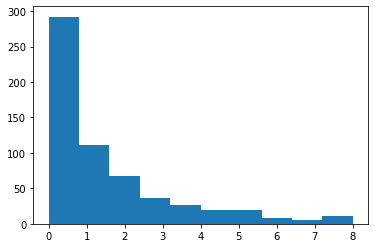

In [289]:
plt.hist(main_df['refactoring_perc_time_taken'])

(array([143.,  73.,  46.,  30.,  54.,  16.,  20.,  21.,  22.,  35.,   7.,
          3.,  12.,   3.,  15.,   7.,   5.,   5.,   4.,  12.,   7.,   5.,
          1.,   7.,   8.,   4.,   4.,   3.,   2.,   4.,   1.,   1.,   1.,
          0.,   2.,   2.,   1.,   3.,   2.,   5.]),
 array([1.20827670e-04, 2.00117807e-01, 4.00114786e-01, 6.00111766e-01,
        8.00108745e-01, 1.00010572e+00, 1.20010270e+00, 1.40009968e+00,
        1.60009666e+00, 1.80009364e+00, 2.00009062e+00, 2.20008760e+00,
        2.40008458e+00, 2.60008156e+00, 2.80007854e+00, 3.00007552e+00,
        3.20007250e+00, 3.40006948e+00, 3.60006646e+00, 3.80006343e+00,
        4.00006041e+00, 4.20005739e+00, 4.40005437e+00, 4.60005135e+00,
        4.80004833e+00, 5.00004531e+00, 5.20004229e+00, 5.40003927e+00,
        5.60003625e+00, 5.80003323e+00, 6.00003021e+00, 6.20002719e+00,
        6.40002417e+00, 6.60002114e+00, 6.80001812e+00, 7.00001510e+00,
        7.20001208e+00, 7.40000906e+00, 7.60000604e+00, 7.80000302e+00,
      

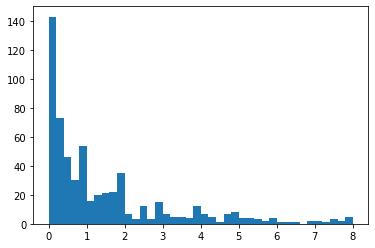

In [290]:
plt.hist(main_df['refactoring_perc_time_taken'],bins=40)

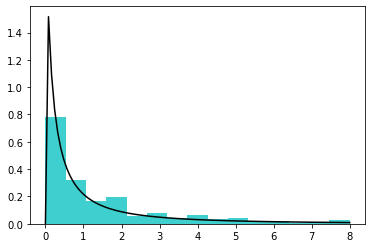

In [291]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

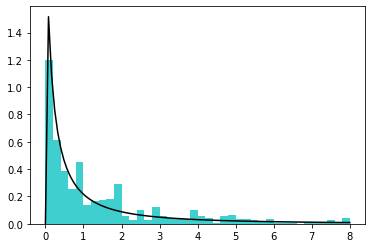

In [292]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

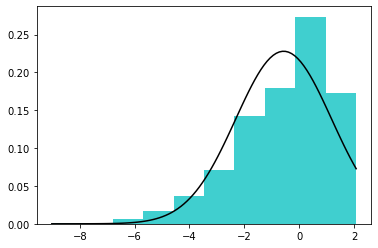

In [293]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [294]:
len(main_df)

596

In [295]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [296]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [297]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [298]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
 'cocomoII_time_taken',
'geneticP_time_taken',
'softwareMaintenance_time_taken',
'fuzzy_time_taken',
'time_taken_final'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [299]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [300]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken')
Y_col = ['refactoring_perc_time_taken']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [301]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
1,12.000000,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,68.000000,68.0,68.0,0.000000,17.000000,17.0,17.0,0.000000,3.000000,78.000000
2,30.000000,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.000000,1.0,...,103.000000,103.0,103.0,0.000000,1.000000,1.0,1.0,0.000000,78.000000,322.000000
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,121.333333,37.0,320.0,98.919006,1.000000,1.0,1.0,0.000000,57.583333,222.666667
4,7.833333,0.0,31.0,11.027514,7.833333,1.0,21.0,7.444746,1.166667,1.0,...,63.500000,8.0,125.0,36.335557,10.333333,1.0,17.0,8.238858,54.333333,88.000000
5,25.000000,25.0,25.0,0.000000,32.000000,32.0,32.0,0.000000,1.000000,1.0,...,166.000000,166.0,166.0,0.000000,1025.000000,1025.0,1025.0,0.000000,51.000000,321.000000


In [302]:
y.head()

,refactoring_perc_time_taken
1,0.225434
2,1.000000
3,3.711340
4,0.012384
5,0.865229


## Feature Engineering

In [303]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 9 mins
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,5 months and 10 days !!!
H2O_cluster_name:,H2O_from_python_tanji_8bvj6r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.788 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [349]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.8], seed=16)


x = train.columns
y = "refactoring_perc_time_taken"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [353]:
full.shape

(596, 163)

In [354]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [355]:
train[y].types

{'refactoring_perc_time_taken': 'real'}

In [356]:
aml = H2OAutoML(max_models=25, seed=16, exclude_algos=['XGBoost','GLM'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█████████████████████████████████████████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmpu514ao5v.csv'
██████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmp7ilohmgx.csv'
█Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmphj3r28v2.csv'
████████| 100%


In [357]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20220213_032636_model_7,2.84869,1.68781,2.84869,1.27414,0.581056
GBM_5_AutoML_20220213_032636,2.84987,1.68816,2.84987,1.27939,0.583618
GBM_grid__1_AutoML_20220213_032636_model_2,2.85447,1.68952,2.85447,1.27759,0.582922
StackedEnsemble_BestOfFamily_AutoML_20220213_032636,2.85747,1.6904,2.85747,1.27675,0.585391
StackedEnsemble_AllModels_AutoML_20220213_032636,2.87695,1.69616,2.87695,1.28145,0.589618
DeepLearning_grid__3_AutoML_20220213_032636_model_1,2.9026,1.7037,2.9026,1.31152,0.608352
GBM_grid__1_AutoML_20220213_032636_model_6,2.92511,1.71029,2.92511,1.26059,0.597824
GBM_grid__1_AutoML_20220213_032636_model_1,2.93189,1.71228,2.93189,1.26612,0.587919
DeepLearning_grid__2_AutoML_20220213_032636_model_1,2.98318,1.72719,2.98318,1.33128,nan
XRT_1_AutoML_20220213_032636,2.98403,1.72744,2.98403,1.28738,0.60111


gbm prediction progress: |████████████████████████████████████████████████| 100%


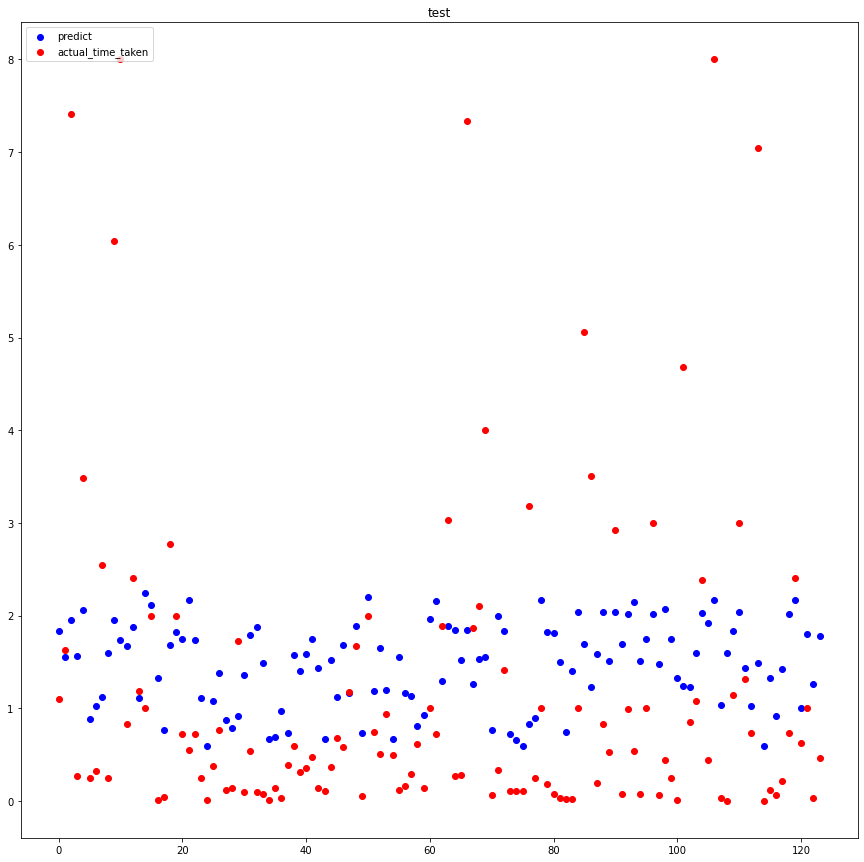

gbm prediction progress: |████████████████████████████████████████████████| 100%


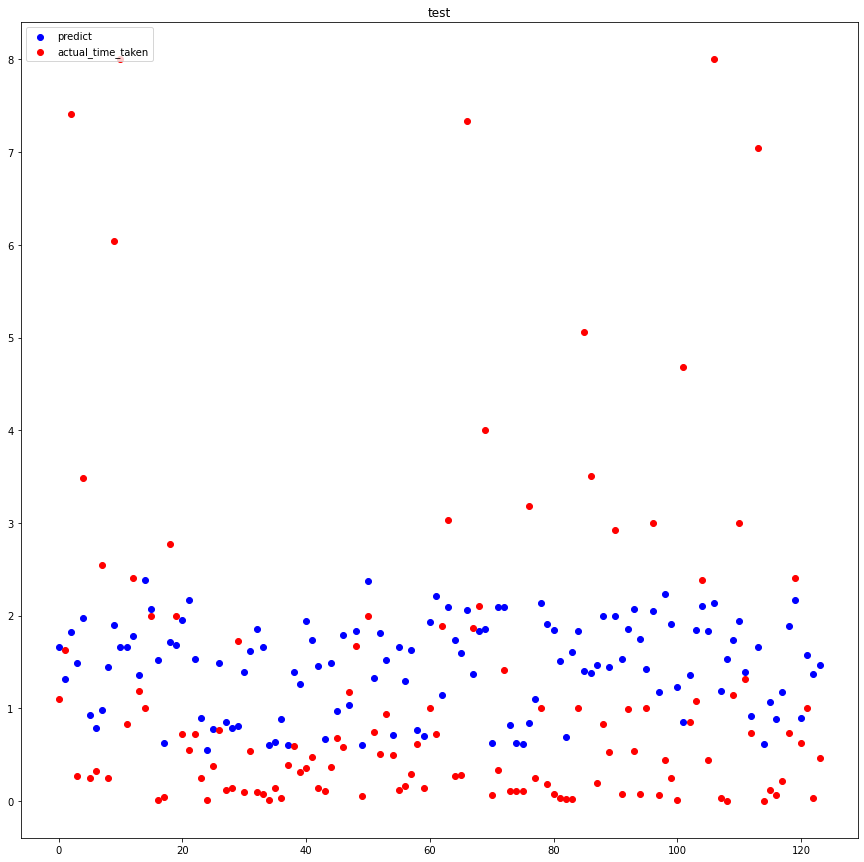

gbm prediction progress: |████████████████████████████████████████████████| 100%


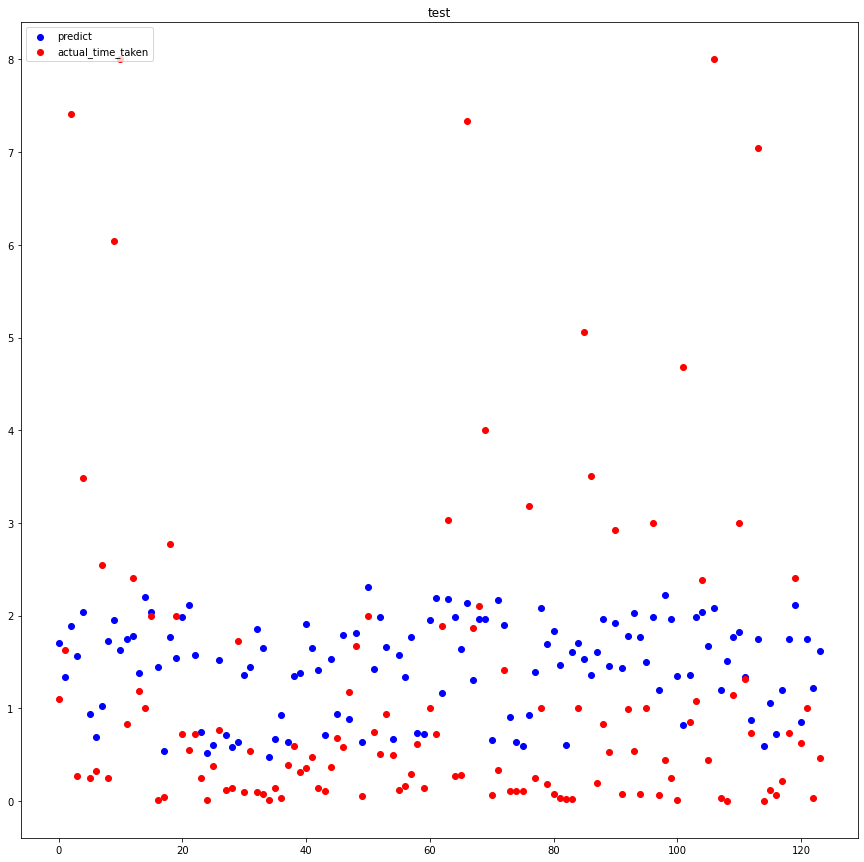

stackedensemble prediction progress: |████████████████████████████████████| 100%


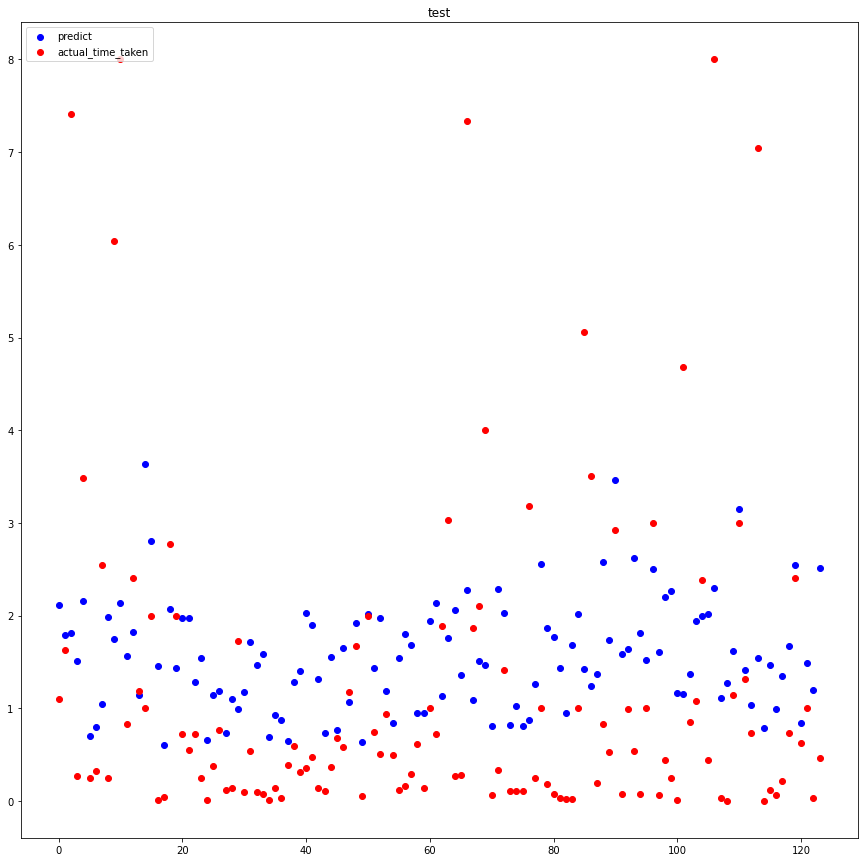

stackedensemble prediction progress: |████████████████████████████████████| 100%


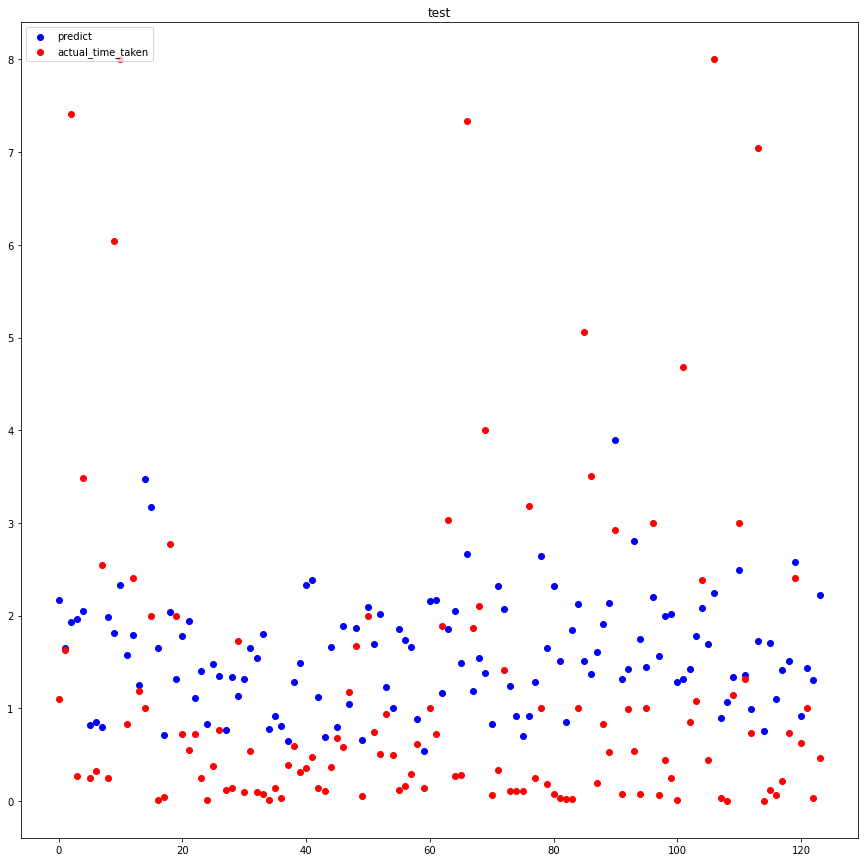

deeplearning prediction progress: |███████████████████████████████████████| 100%


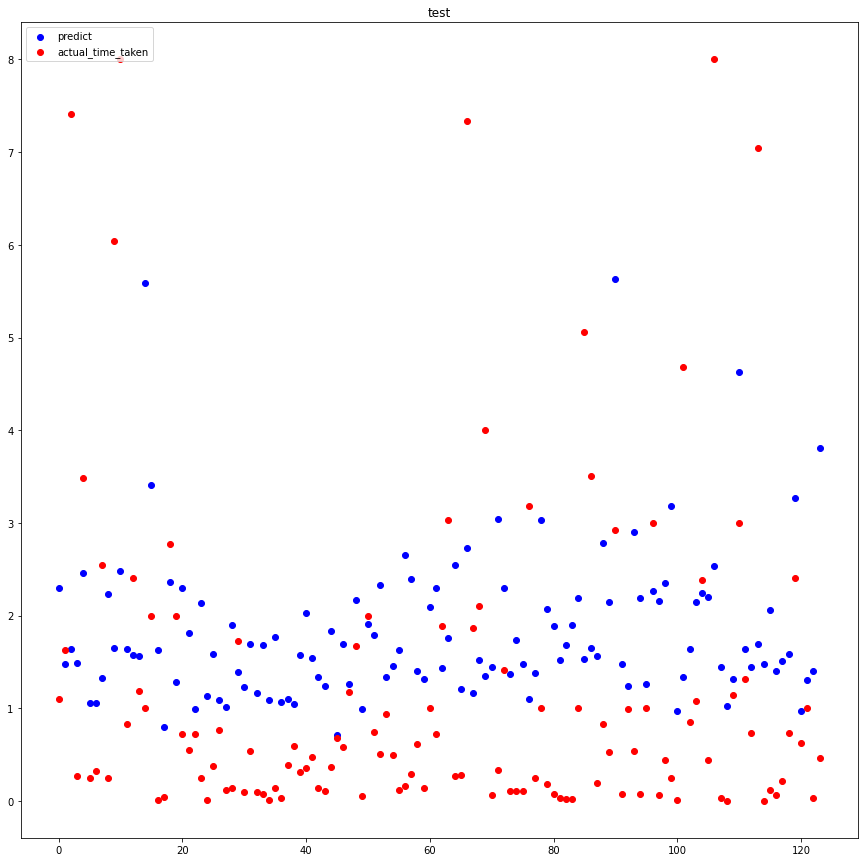

gbm prediction progress: |████████████████████████████████████████████████| 100%


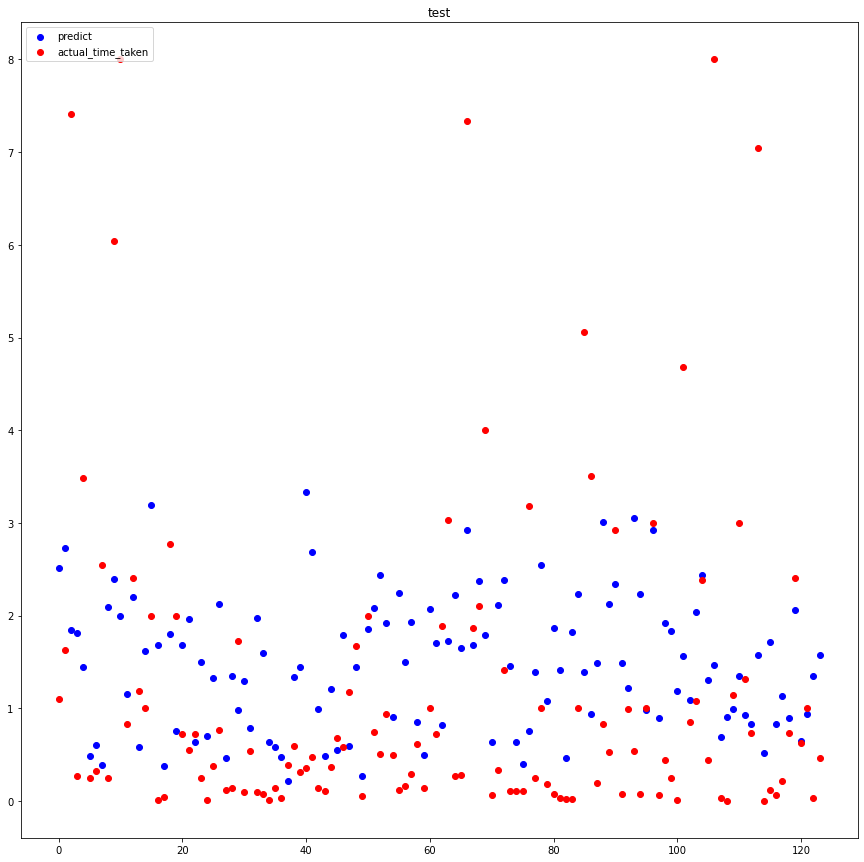

gbm prediction progress: |████████████████████████████████████████████████| 100%


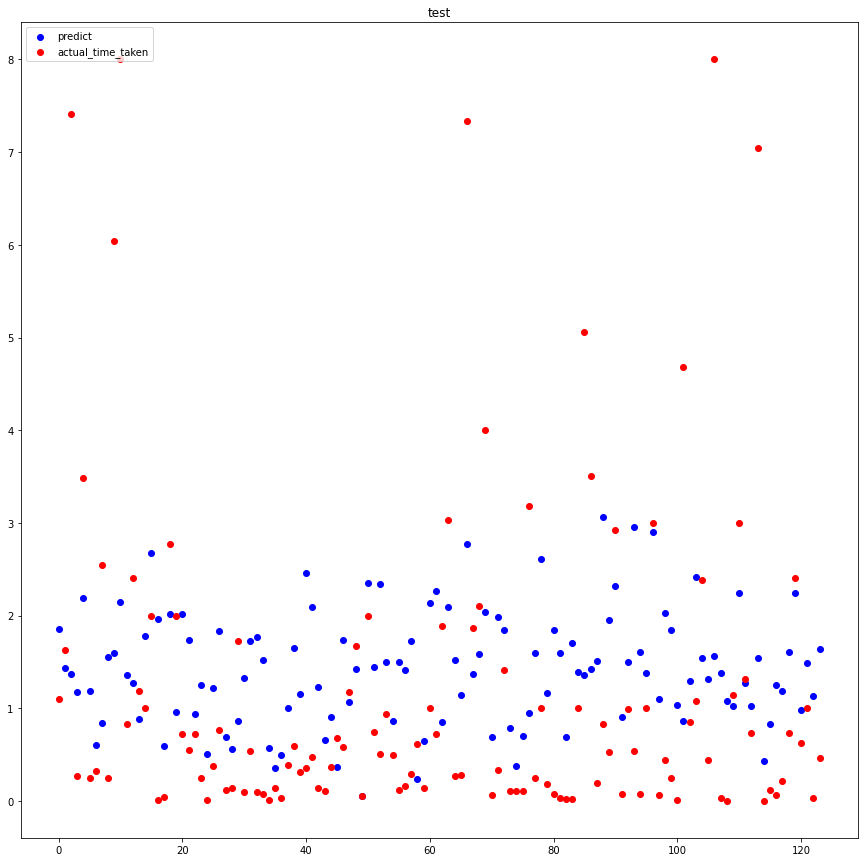

deeplearning prediction progress: |███████████████████████████████████████| 100%


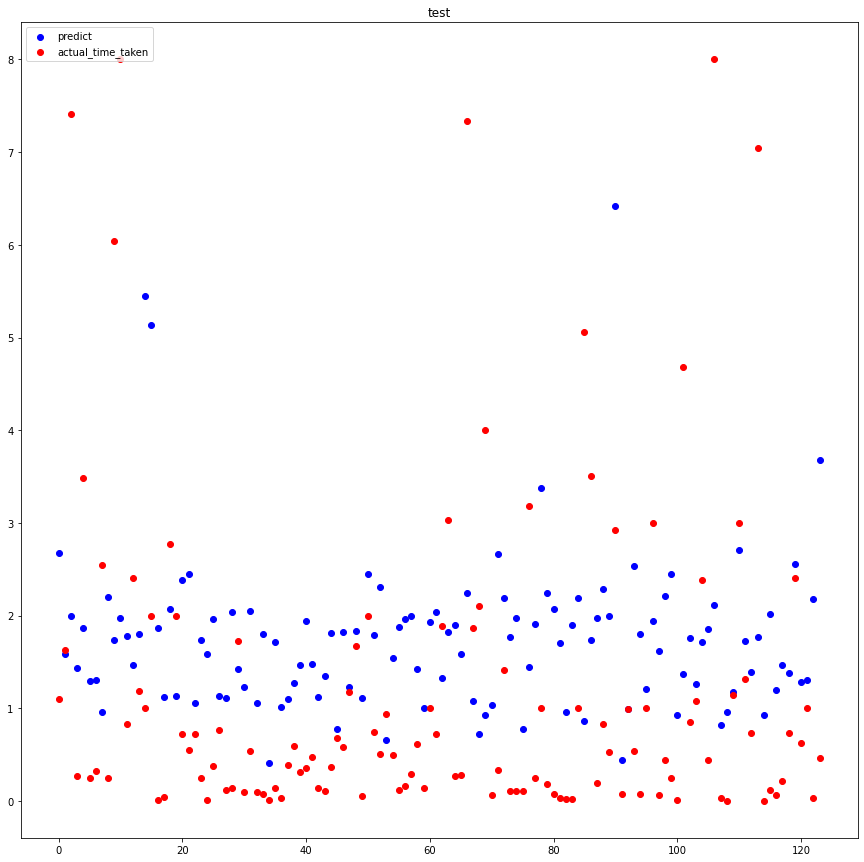

drf prediction progress: |████████████████████████████████████████████████| 100%


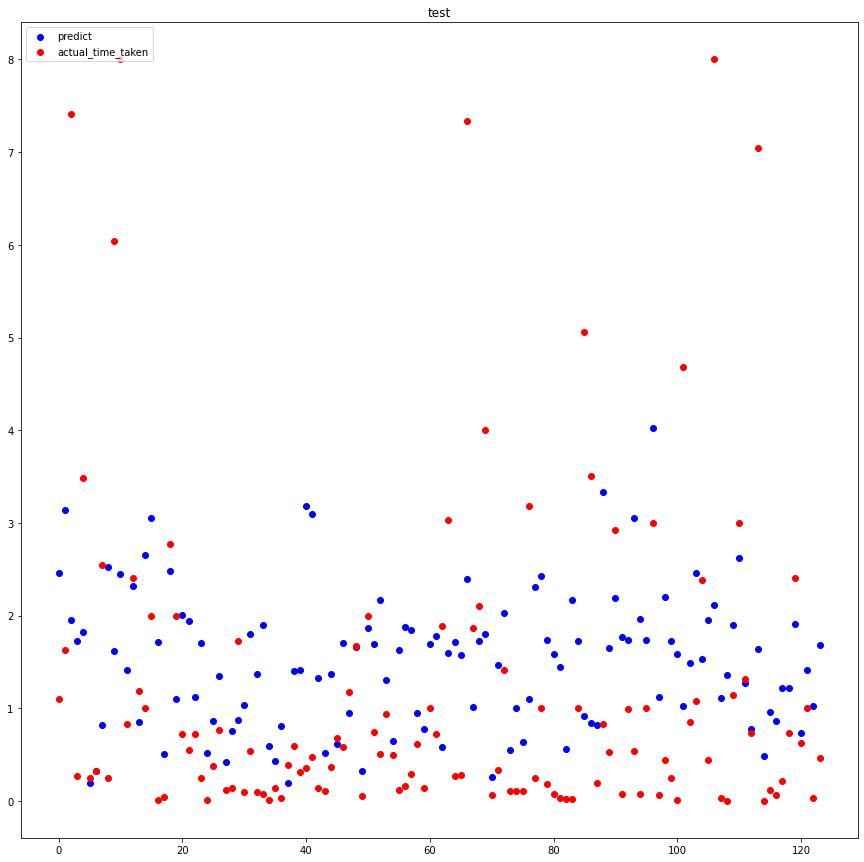

gbm prediction progress: |████████████████████████████████████████████████| 100%


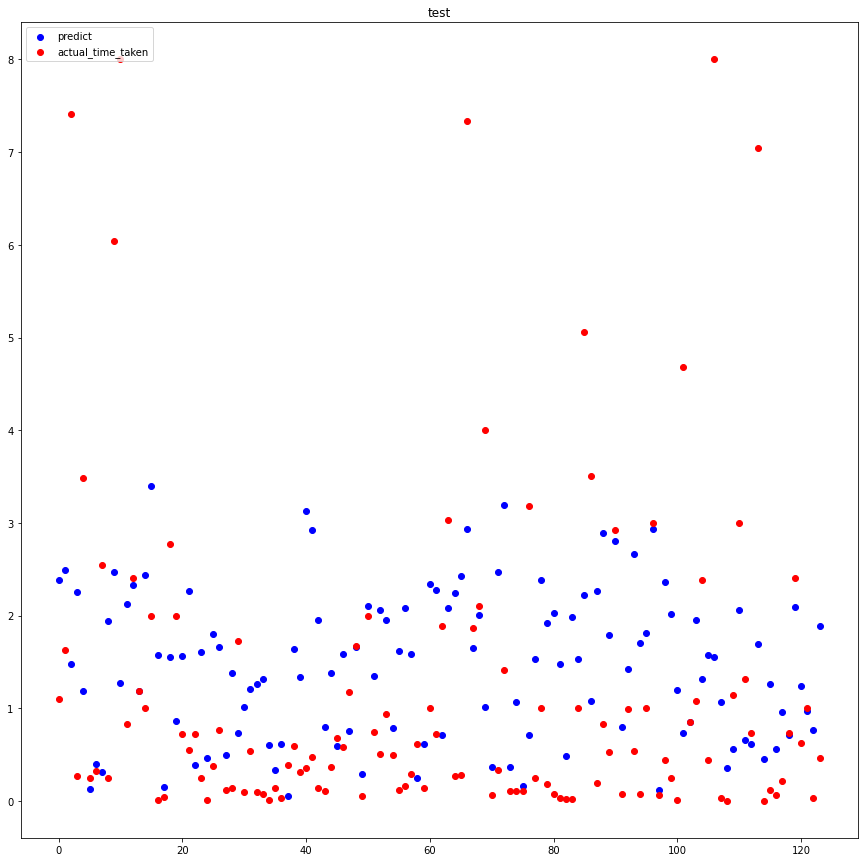

gbm prediction progress: |████████████████████████████████████████████████| 100%


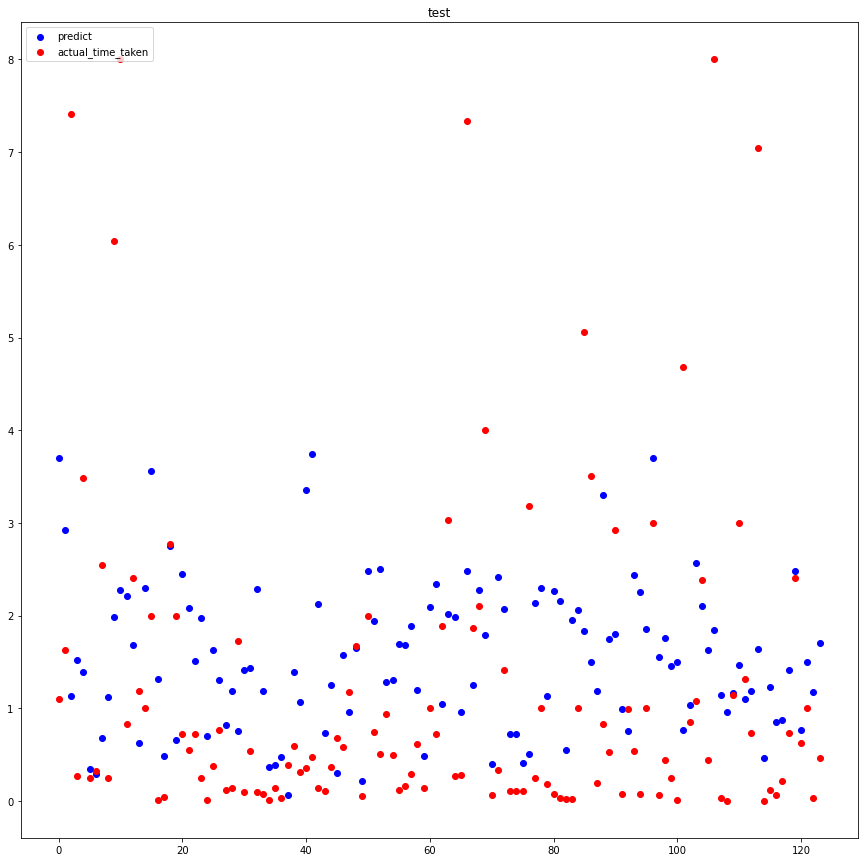

gbm prediction progress: |████████████████████████████████████████████████| 100%


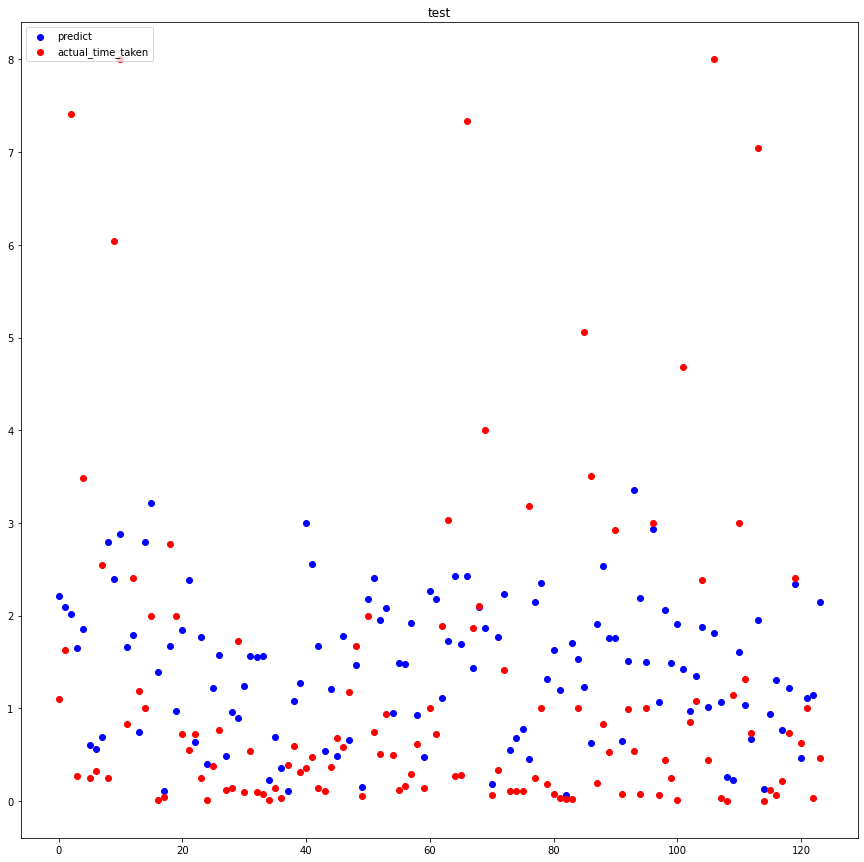

gbm prediction progress: |████████████████████████████████████████████████| 100%


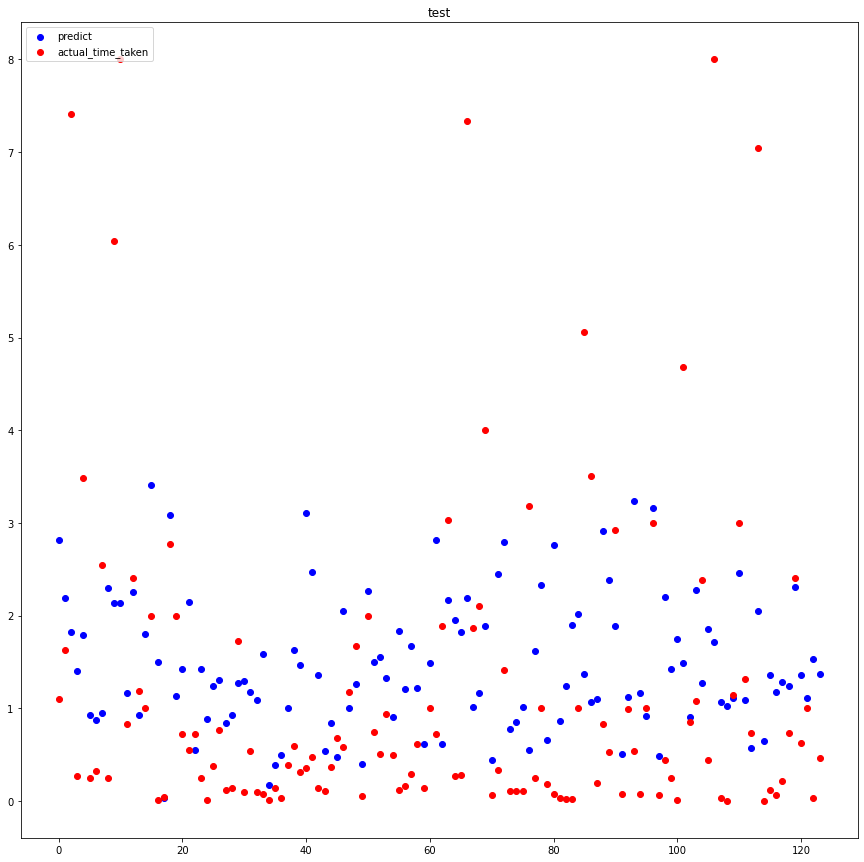

gbm prediction progress: |████████████████████████████████████████████████| 100%


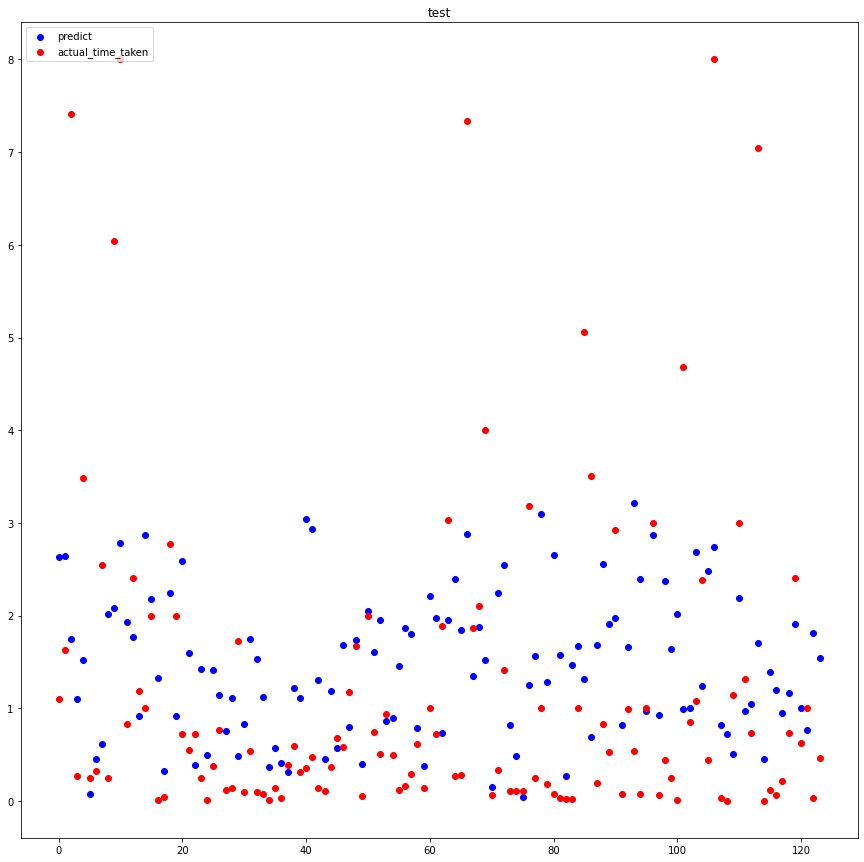

drf prediction progress: |████████████████████████████████████████████████| 100%


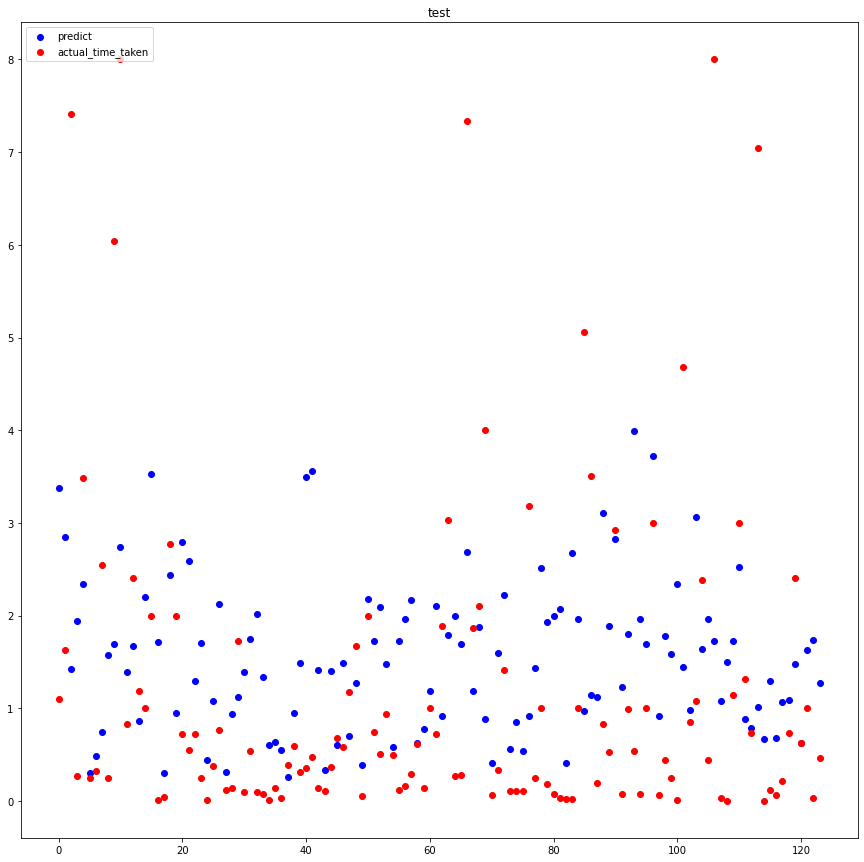

gbm prediction progress: |████████████████████████████████████████████████| 100%


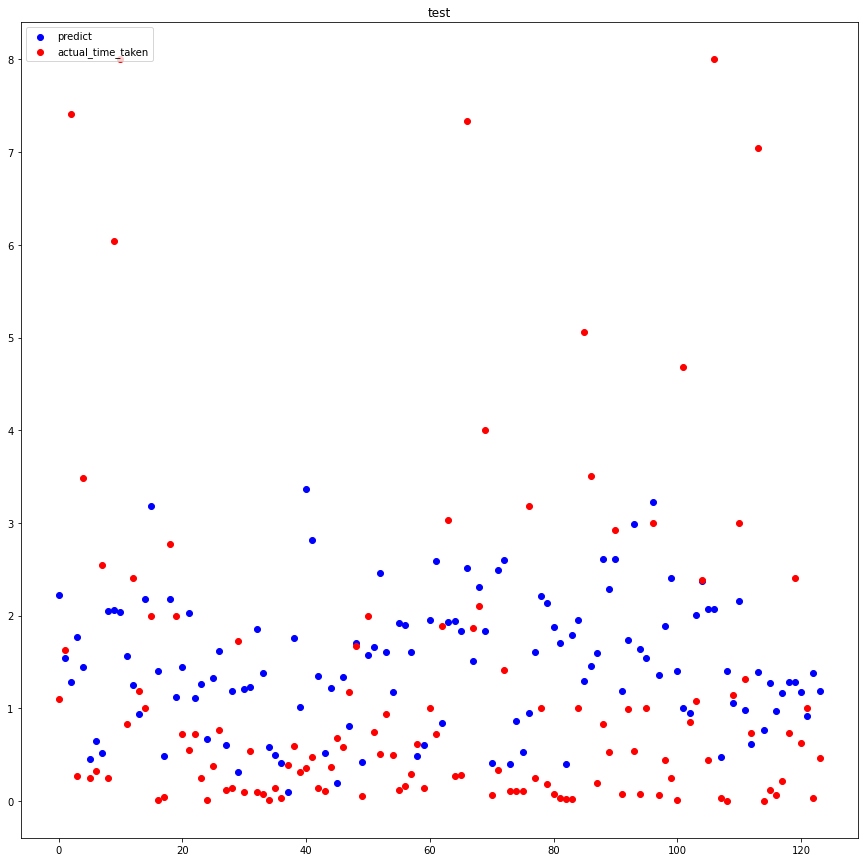

deeplearning prediction progress: |███████████████████████████████████████| 100%


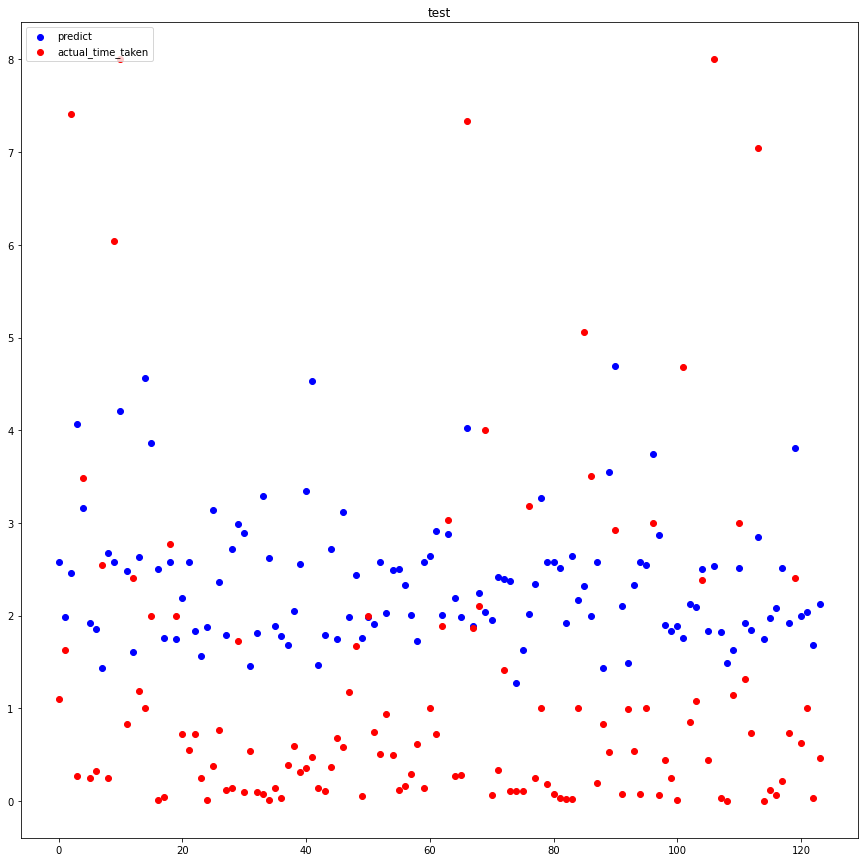

deeplearning prediction progress: |███████████████████████████████████████| 100%


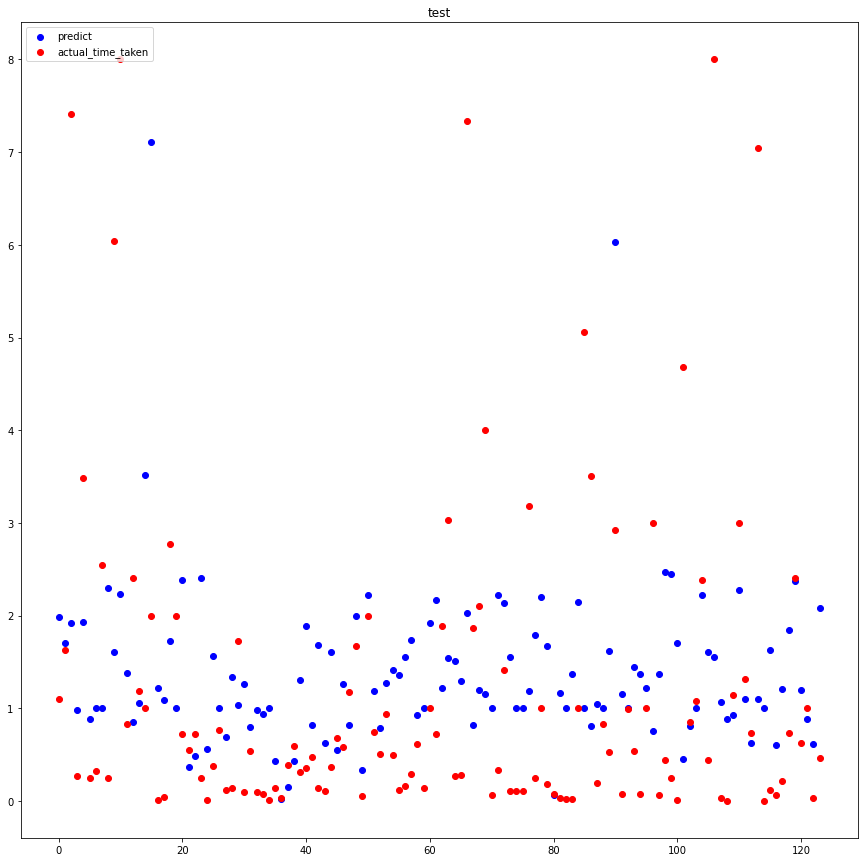

gbm prediction progress: |████████████████████████████████████████████████| 100%


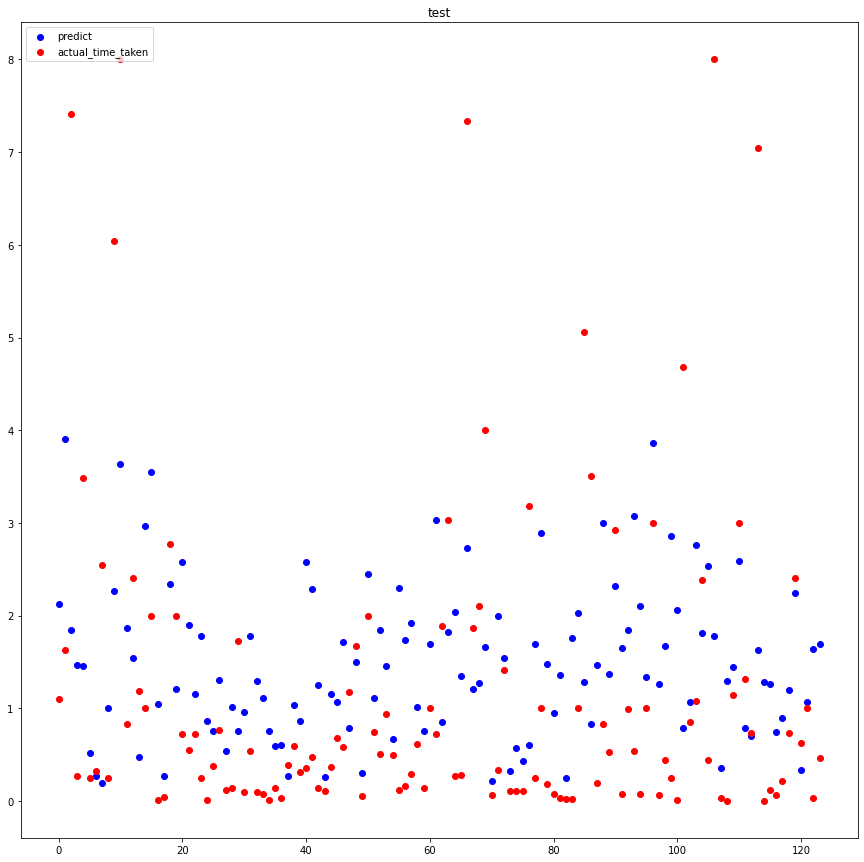

gbm prediction progress: |████████████████████████████████████████████████| 100%


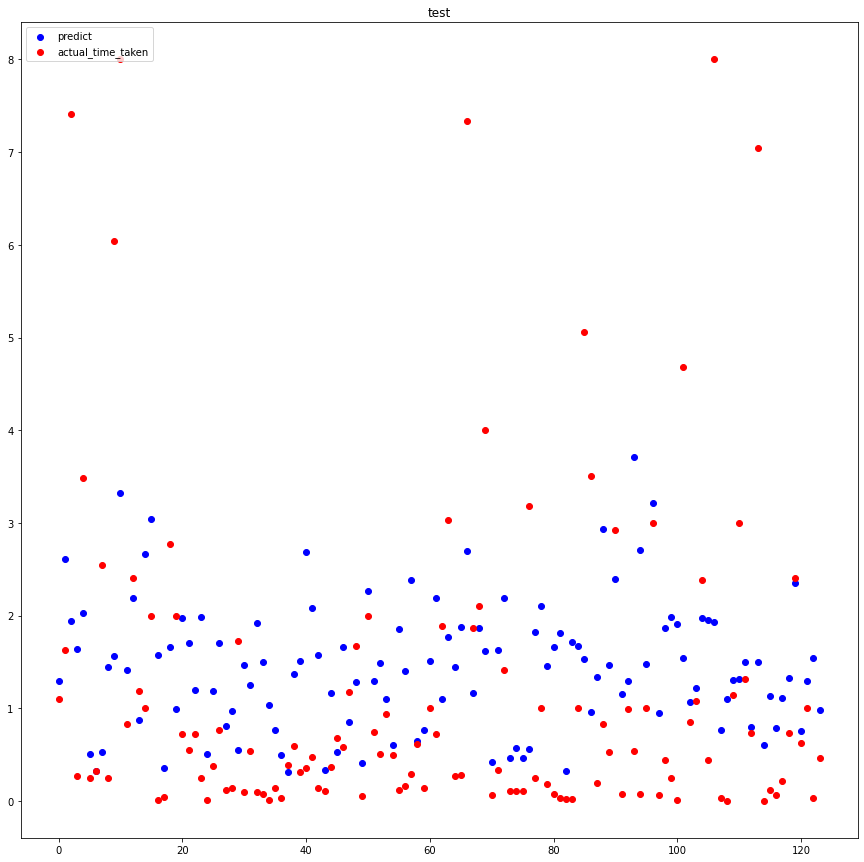

deeplearning prediction progress: |███████████████████████████████████████| 100%


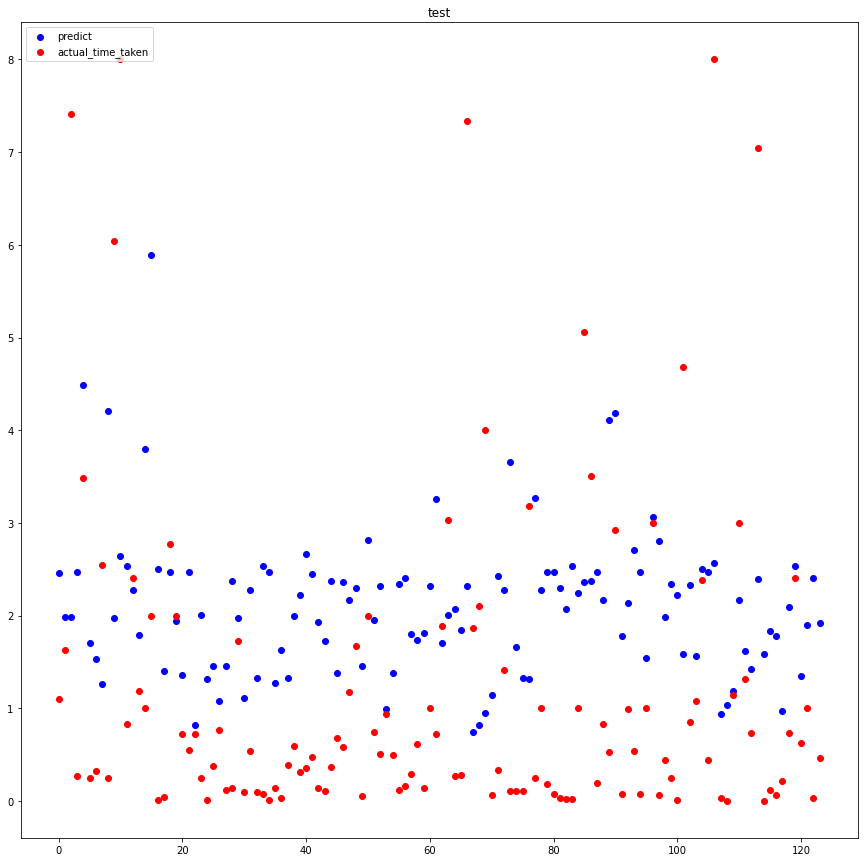

deeplearning prediction progress: |███████████████████████████████████████| 100%


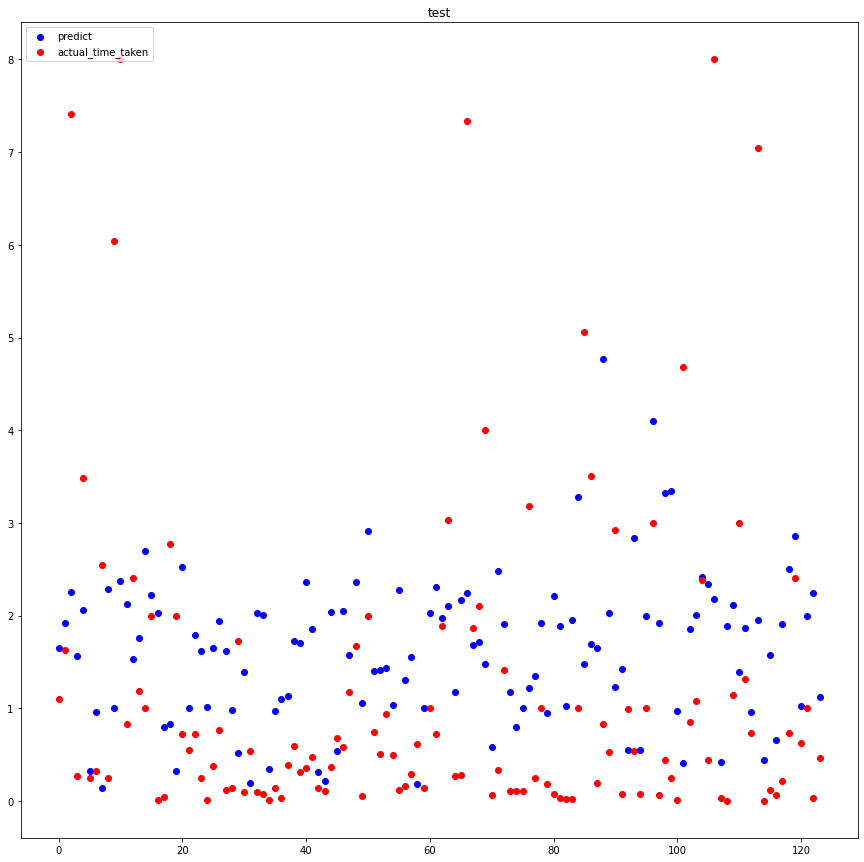

deeplearning prediction progress: |███████████████████████████████████████| 100%


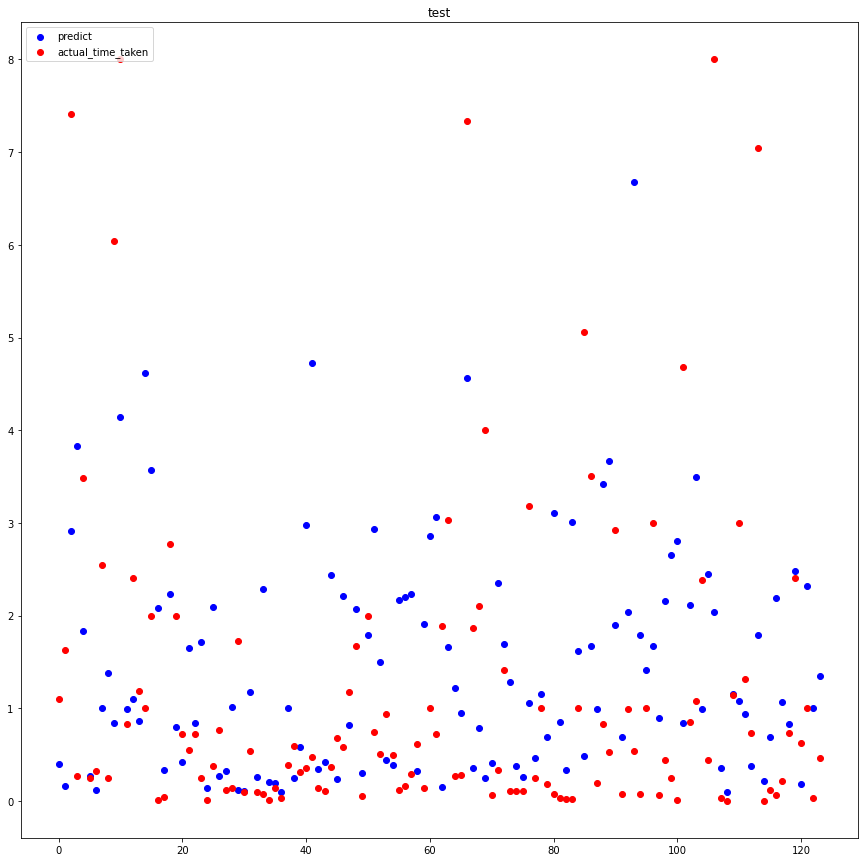

deeplearning prediction progress: |███████████████████████████████████████| 100%


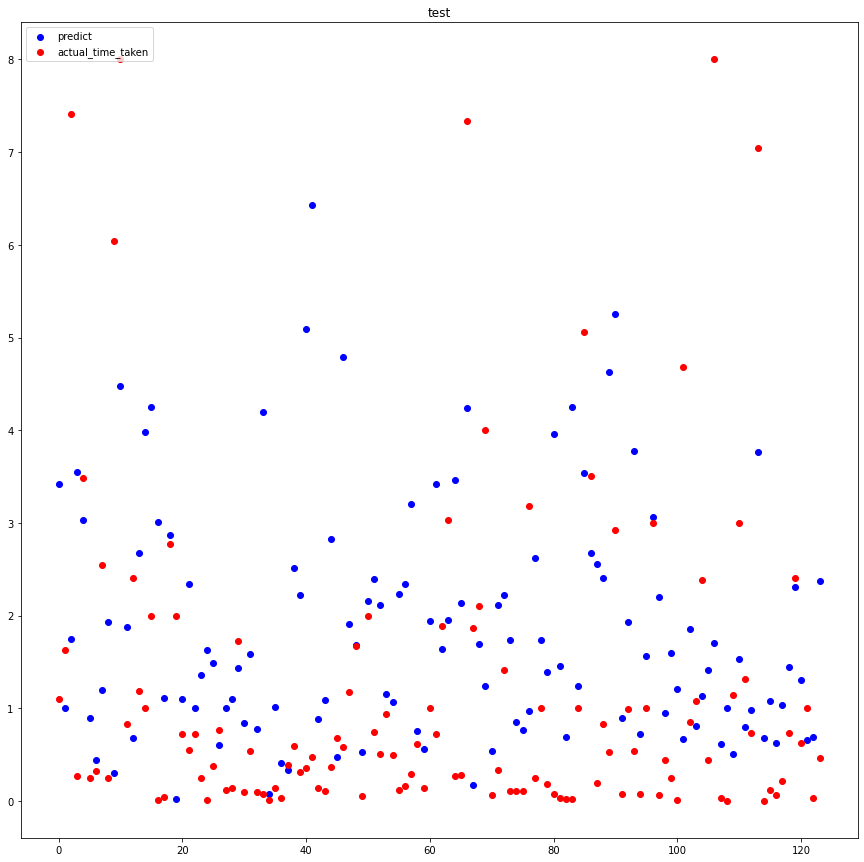

In [513]:
for i in range(25):
    model = h2o.get_model(lb[i,'model_id'])
    preds = model.predict(test)
    pd_preds = preds.as_data_frame()
    pd_test = test.as_data_frame()
    pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']
    pd_preds.loc[(pd_preds.predict < 0),'predict']=1
    plotGraphandSave(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken','test', i)
    

In [514]:
model = h2o.get_model(lb[23,'model_id'])

In [515]:
model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid__3_AutoML_20220213_032636_model_2


Status of Neuron Layers: predicting refactoring_perc_time_taken, regression, gaussian distribution, Quadratic loss, 12,851 weights/biases, 178.1 KB, 910,960 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,153,Input,5,,,,,,,,,
1,,2,50,RectifierDropout,0,0,0,0.0908892,0.0994889,0,0.0171073,0.363563,-0.0320848,0.491748
2,,3,50,RectifierDropout,0,0,0,0.0108742,0.00991578,0,-0.0744691,0.225013,0.941249,0.247045
3,,4,50,RectifierDropout,0,0,0,0.0192461,0.0163549,0,-0.0910285,0.248271,0.826736,0.395349
4,,5,1,Linear,,0,0,0.00279198,0.00158549,0,0.0184014,0.188057,0.363425,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.15125890158680197
RMSE: 0.38892017379765986
MAE: 0.1850543680809389
RMSLE: 0.1527500623087787
Mean Residual Deviance: 0.15125890158680197

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 3.7540318204869165
RMSE: 1.9375324050159566
MAE: 1.4202987314187163
RMSLE: NaN
Mean Residual Deviance: 3.7540318204869165

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1.4203107,0.11981835,1.4786175,1.3563503,1.6046314,1.3308542,1.3311001
1,mean_residual_deviance,3.7535255,0.6248169,4.05567,3.6903152,4.6473727,3.0736911,3.3005793
2,mse,3.7535255,0.6248169,4.05567,3.6903152,4.6473727,3.0736911,3.3005793
3,r2,-0.25485796,0.32970867,-0.13028198,-0.08823801,-0.82597363,-0.22935145,-4.4466698E-4
4,residual_deviance,3.7535255,0.6248169,4.05567,3.6903152,4.6473727,3.0736911,3.3005793
5,rmse,1.9321219,0.15980698,2.0138693,1.9210193,2.1557767,1.7531946,1.8167497
6,rmsle,0.68066967,0.07141865,0.68840635,NaN,0.7787221,0.6317789,0.6237713



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-02-13 03:38:33,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-02-13 03:38:34,2 min 54.358 sec,22476 obs/sec,10.0,1,4720.0,1.926765,3.712425,1.417806,-0.198795
2,,2022-02-13 03:38:39,2 min 59.407 sec,32347 obs/sec,360.0,36,169920.0,0.617196,0.380931,0.406350,0.876992
3,,2022-02-13 03:38:44,3 min 4.455 sec,33923 obs/sec,740.0,74,349280.0,0.516230,0.266494,0.288174,0.913945
4,,2022-02-13 03:38:49,3 min 9.513 sec,34748 obs/sec,1130.0,113,533360.0,0.383320,0.146934,0.193688,0.952553
5,,2022-02-13 03:38:54,3 min 14.516 sec,35260 obs/sec,1520.0,152,717440.0,0.415864,0.172943,0.220559,0.944154
6,,2022-02-13 03:38:59,3 min 19.602 sec,35639 obs/sec,1920.0,192,906240.0,0.468708,0.219688,0.237175,0.929060
7,,2022-02-13 03:38:59,3 min 19.735 sec,35647 obs/sec,1930.0,193,910960.0,0.388920,0.151259,0.185054,0.951156



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,num_dependency_mean,1.000000,1.000000,0.014757
1,subClassesQty_min,0.944012,0.944012,0.013930
2,subClassesQty_mean,0.874474,0.874474,0.012904
3,lambdasQty_min,0.772075,0.772075,0.011393
4,cbo_min,0.770119,0.770119,0.011364
5,nosi_min,0.739985,0.739985,0.010920
6,anonymousClassesQty_min,0.711506,0.711506,0.010499
7,num_line_affected_mean,0.687200,0.687200,0.010141
8,staticMethods_min,0.663538,0.663538,0.009792
9,dit_min,0.649723,0.649723,0.009588



See the whole table with table.as_data_frame()


In [516]:
preds = model.predict(test)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [517]:
preds

predict
0.39569
0.156619
2.90817
3.82871
1.83015
0.274567
0.113772
-0.0510615
1.37667
0.846256


In [518]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

0.384359    1
2.802297    1
3.112373    1
0.845239    1
0.179197    1
           ..
2.200600    1
1.500030    1
0.420979    1
2.856475    1
1.719957    1
Name: predict, Length: 124, dtype: int64

In [519]:
train.head()

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken
12,12,12,0,8,8,8,0,1,1,1,0,16,16,16,0,0,0,0,0,2,2,2,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,0,5,5,5,0,2,2,2,0,8,8,8,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,4,4,4,0,80,80,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,2,2,2,0,16,16,16,0,0,0,0,0,16,16,16,0,1,1,1,0,2,2,2,0,0,0,0,0,0,0,0,0,68,68,68,0,17,17,17,0,3,78,0.225434
30,30,30,0,29,29,29,0,1,1,1,0,78,78,78,0,0,0,0,0,27,27,27,0,0,0,0,0,27,27,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12,0,0,0,0,0,2,2,2,0,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,0,350,350,350,0,0,0,0,0,2,2,2,0,0,0,0,0,1,1,1,0,0,0,0,0,24,24,24,0,72,72,72,0,82,82,82,0,5,5,5,0,81,81,81,0,1,1,1,0,0,0,0,0,0,0,0,0,6,6,6,0,103,103,103,0,1,1,1,0,78,322,1
23.25,5,63,20.7808,20.6667,4,64,21.9931,2,1,3,0.852803,40.4167,3,111,41.3597,27.1667,0,106,39.3512,15,3,37,13.1978,0.166667,0,1,0.389249,13.1667,3,35,13.4221,0.25,0,1,0.452267,1.33333,0,4,1.96946,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0,1,0.389249,7.66667,2,21,7.30297,1.66667,0,6,2.14617,1.16667,0,5,1.94625,6.5,2,21,7.42845,0,0,0,0,0,0,0,0,4,0,13,4.82418,0,0,0,0,7.91667,0,36,13.2216,193.583,37,531,191.017,6.5,0,24,8.5227,1.08333,0,2,0.668558,0.333333,0,2,0.778499,2.58333,0,15,5.80687,0.6

{'whiskers': [<matplotlib.lines.Line2D at 0x25db1400e80>,
 'caps': [<matplotlib.lines.Line2D at 0x25db140b5f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x25db1400d30>],
 'medians': [<matplotlib.lines.Line2D at 0x25db140bcf8>],
 'fliers': [<matplotlib.lines.Line2D at 0x25db14110b8>],
 'means': []}

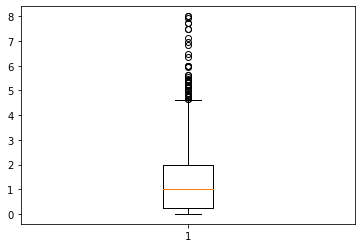

In [520]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x25db144a3c8>,
 'caps': [<matplotlib.lines.Line2D at 0x25db17635f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x25db144ad68>],
 'medians': [<matplotlib.lines.Line2D at 0x25db1763cf8>],
 'fliers': [<matplotlib.lines.Line2D at 0x25db176a0b8>],
 'means': []}

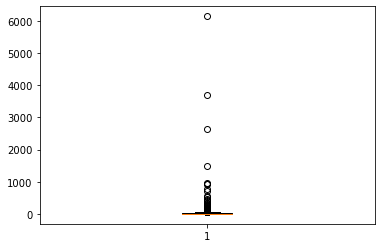

In [521]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [522]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x25db098a668>,
 'caps': [<matplotlib.lines.Line2D at 0x25db17c70b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x25db17b8828>],
 'medians': [<matplotlib.lines.Line2D at 0x25db17c7780>],
 'fliers': [<matplotlib.lines.Line2D at 0x25db17c7ac8>],
 'means': []}

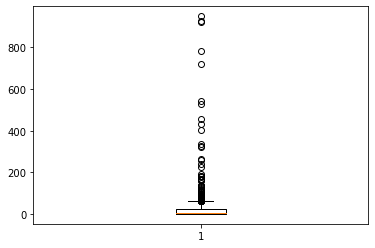

In [523]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x25db17db0b8>,
 'caps': [<matplotlib.lines.Line2D at 0x25db18247f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x25db1816f60>],
 'medians': [<matplotlib.lines.Line2D at 0x25db1824ef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x25db182f2b0>],
 'means': []}

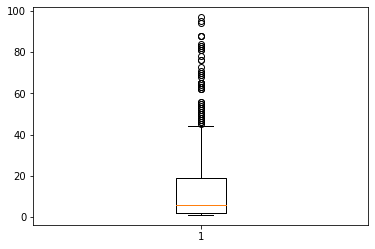

In [524]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [525]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [526]:
pd_preds.head()

,predict,actual_time_taken
0,0.395690,1.097143
1,0.156619,1.628571
2,2.908174,7.411236
3,3.828710,0.268657
4,1.830154,3.480952


In [527]:
pd_preds.loc[(pd_preds.predict < 0),'predict']=1

In [528]:
pd_preds

,predict,actual_time_taken
0,0.395690,1.097143
1,0.156619,1.628571
2,2.908174,7.411236
3,3.828710,0.268657
4,1.830154,3.480952
...,...,...
119,2.478200,2.403670
120,0.179197,0.626950
121,2.318979,1.001036
122,1.000000,0.032273


{'whiskers': [<matplotlib.lines.Line2D at 0x25db18409b0>,
 'caps': [<matplotlib.lines.Line2D at 0x25db1eca9b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x25db1eca160>],
 'medians': [<matplotlib.lines.Line2D at 0x25db1ed20f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x25db1ed2470>],
 'means': []}

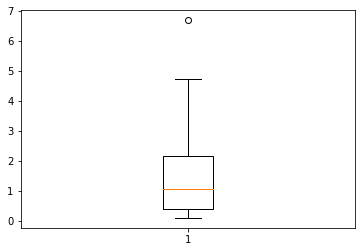

In [529]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x25db18987f0>,
 'caps': [<matplotlib.lines.Line2D at 0x25db18aec88>,
 'boxes': [<matplotlib.lines.Line2D at 0x25db18ae438>],
 'medians': [<matplotlib.lines.Line2D at 0x25db18ba278>],
 'fliers': [<matplotlib.lines.Line2D at 0x25db18ba6a0>],
 'means': []}

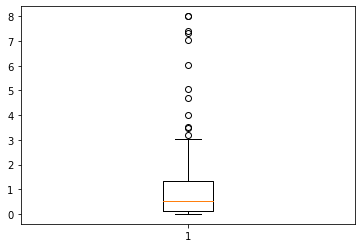

In [530]:
plt.boxplot(pd_preds['actual_time_taken'])

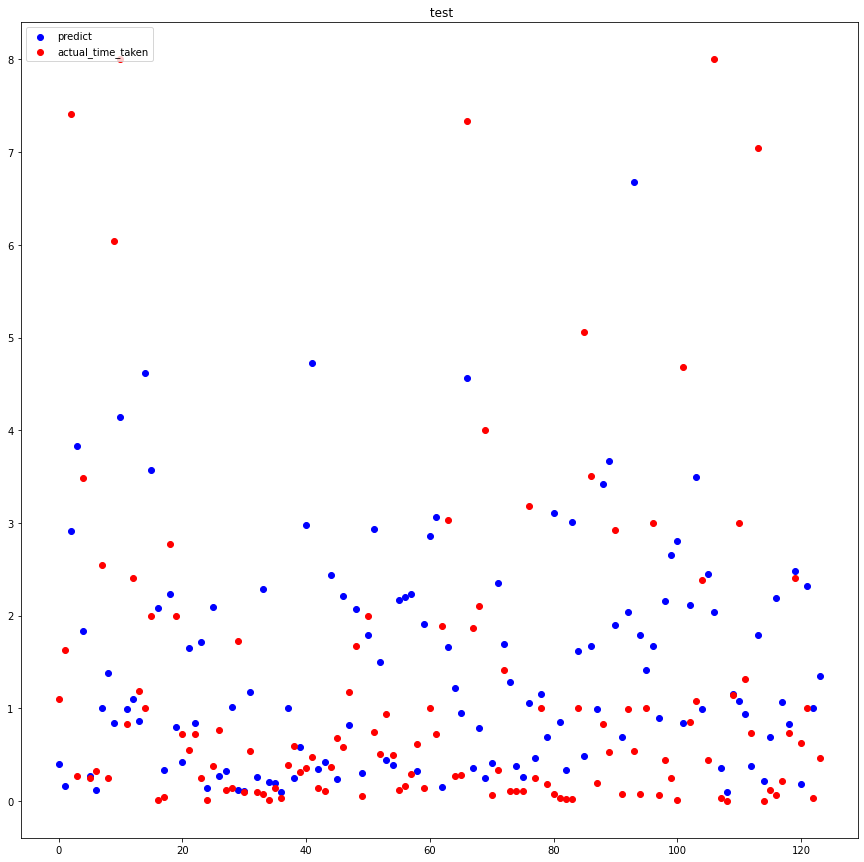

In [531]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken',' test')

In [532]:
visualization = pd_preds[pd_preds['predict'] <= 20]
visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]


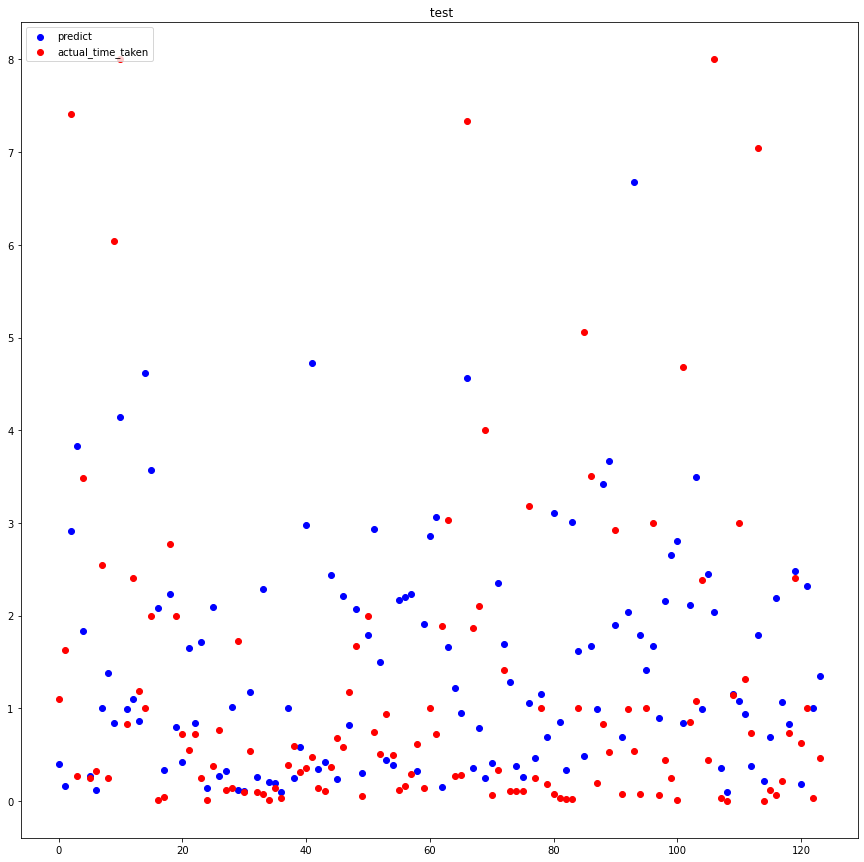

In [533]:
plotGraph(visualization['predict'], visualization['actual_time_taken'],'predict','actual_time_taken',' test')

In [534]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

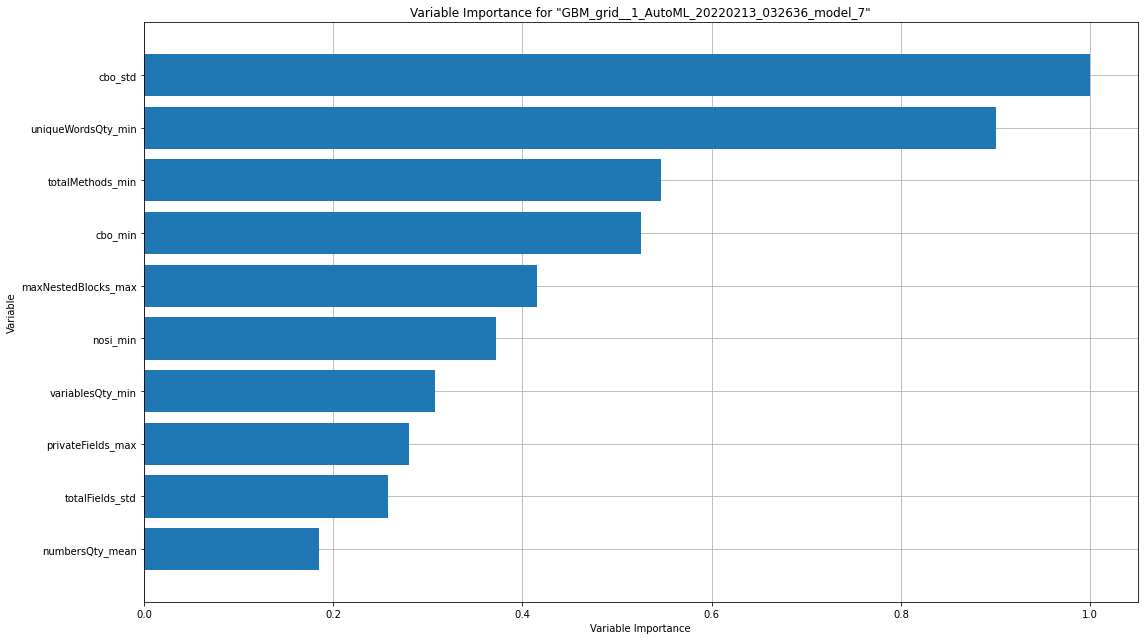

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

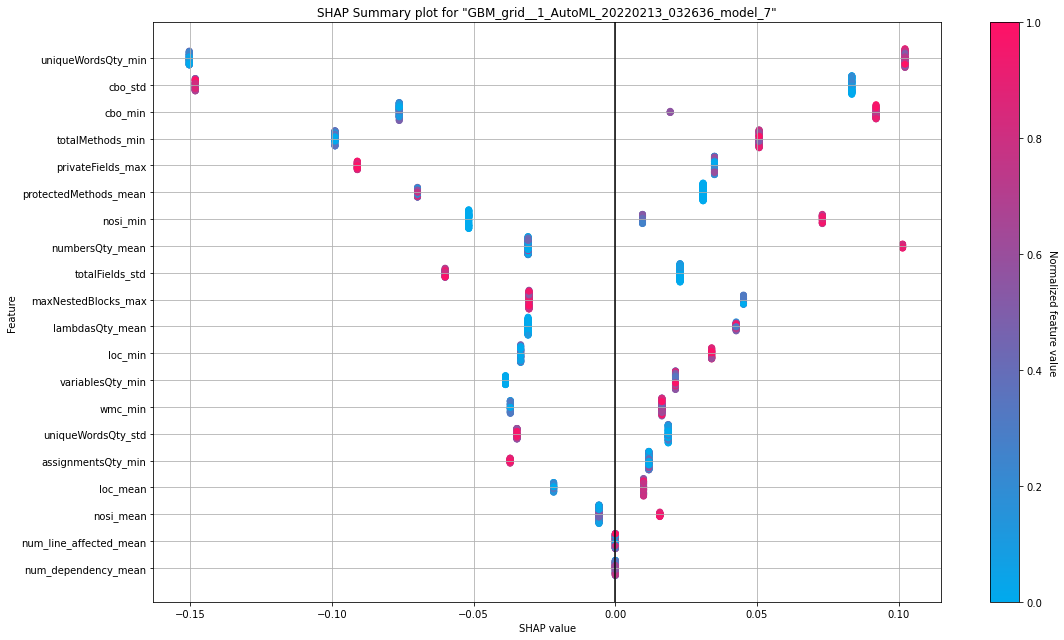

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

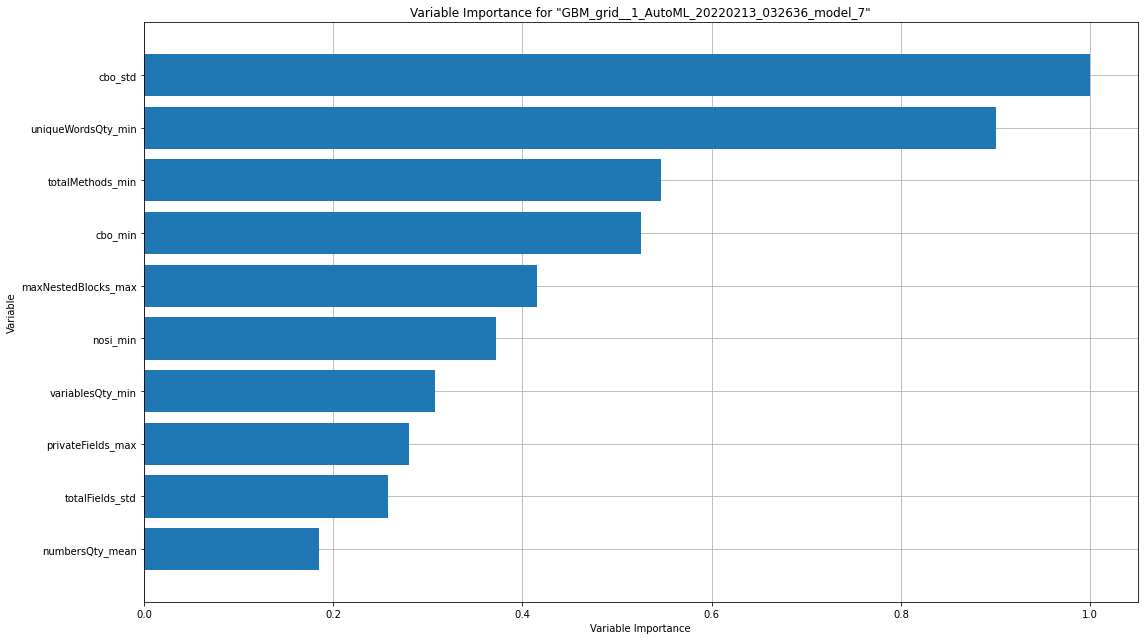

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

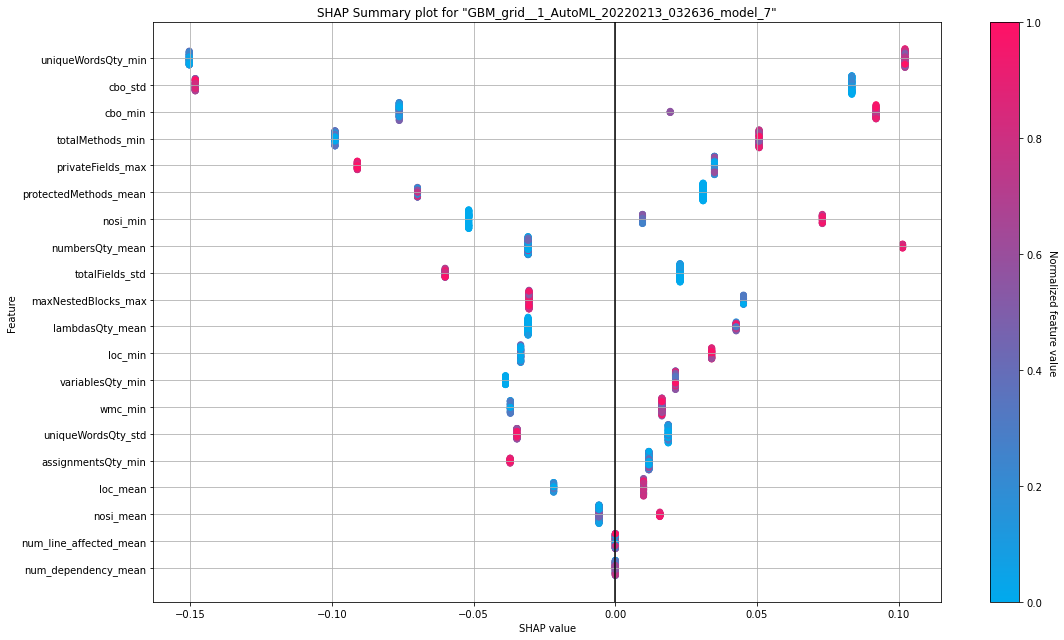

In [535]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [ ]:
## Test calling of model

model_path = "models/EffortEstimationModelv2/GBM_lr_annealing_selection__AutoML_20220206_202721_select_model"
saved_model = h2o.load_model(model_path)

In [ ]:
preds_read_model = model.predict(test)
pd_preds_read_model = preds_read_model.as_data_frame()
pd_preds_read_model['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [ ]:
plotGraph(pd_preds_read_model['predict'], pd_preds_read_model['actual_time_taken'],'predict','actual_time_taken',' test')

In [ ]:
#aml.explain_row(test, row_index=0)

In [ ]:
#h2o.shutdown()